In [1]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

import torch

import pandas as pd

from src.utils import plot_embeddings, pretty_confusion_matrix, ms_label2id, ms_id2label

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [2]:

def show_results(file_name: str, plot_hidden_states = True, plot_title:str = "") -> None:
    results = torch.load(paths.RESULTS_PATH / "ms-diag" / f"{file_name}")

    # Plot confusion matrix
    display_label_mapping = {0: "PPMS", 1: "RRMS", 2: "SPMS", 3: "Other"}
    pretty_confusion_matrix(y_true=results["labels"], y_pred=results["preds"], label_dict=display_label_mapping, title= plot_title)

    # Plot embeddings
    if plot_hidden_states:
        # Exclude None values (for pipeline approach this is to be expected)
        results["last_hidden_state"] = [batch for batch in results["last_hidden_state"] if batch is not None]
        plot_labels = [results["labels"][i] for i in range(len(results["last_hidden_state"])) if results["last_hidden_state"][i] is not None]
        # plot_labels = [display_label_mapping[label] for label in plot_labels]
        
        # Last hidden states is a list of tensors of shape (seq_len, hidden_size)
        last_hidden_state = [batch[0, :] for batch in results["last_hidden_state"]]  # Use CLS token
        embeddings = torch.stack(last_hidden_state, dim=0).to(torch.float16)
        plot_embeddings(embeddings=embeddings, labels=plot_labels, title=plot_title, method="umap", display_label_mapping=display_label_mapping)
        plt.show()

    # Print classification report
    labels = [display_label_mapping[label] for label in results["labels"]]
    preds = [display_label_mapping[pred] for pred in results["preds"]]
    print(classification_report(y_true=labels, y_pred=preds), "\n\n")

    # Show all wrongly classified samples
    for i in range(len(labels)):
        if labels[i] != preds[i]:
            print(f"Observation: {i}")
            print(f"Label: {labels[i]} - Prediction: {preds[i]}")
            try:
                print(results["text"][i])
            except:
                print(results["original_text"][i])
            # Print the probabilities for each class by converting the logits to probabilities, then rounding them
            print("Probabilities:", dict(zip(ms_label2id.keys(), [round(prob, 3) for prob in torch.softmax(torch.tensor(results["logits"][i]), dim=0).numpy()])), "\n\n")

# MedBERT 512

## Strategy: Classify on single lines, 4 Labels (including no MS) and oversampling for training

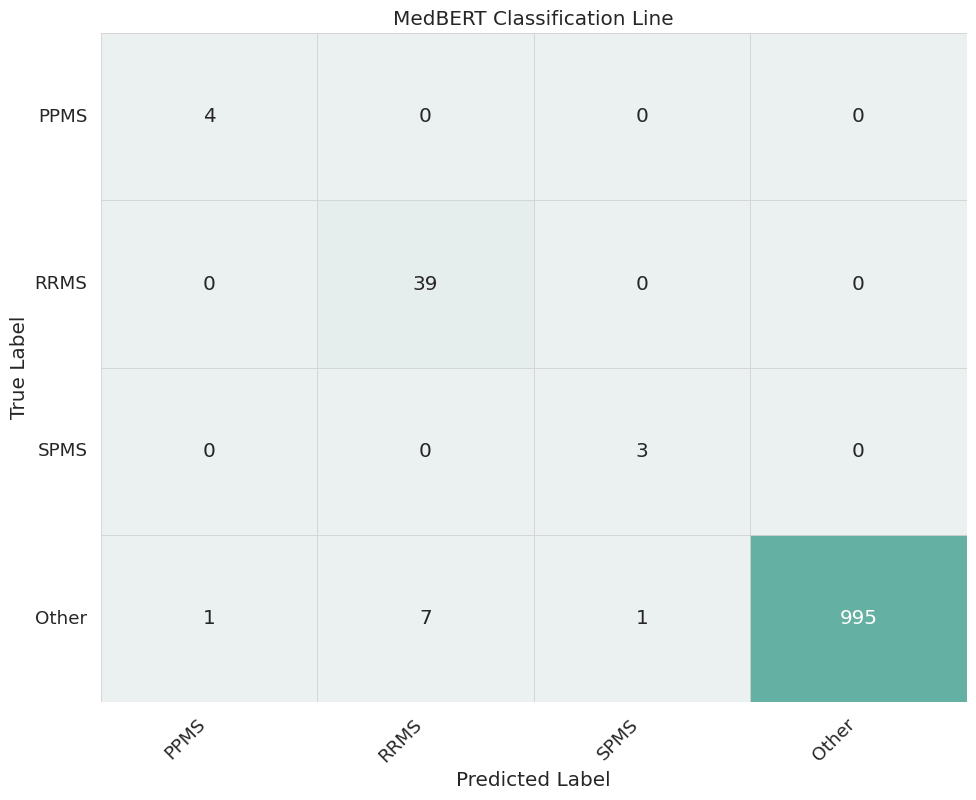

(1050, 2)


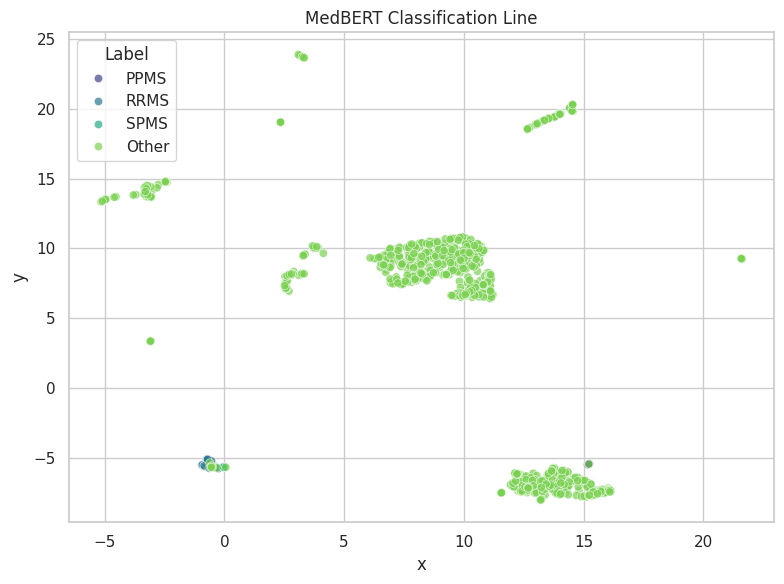

              precision    recall  f1-score   support

       Other       1.00      0.99      1.00      1004
        PPMS       0.80      1.00      0.89         4
        RRMS       0.85      1.00      0.92        39
        SPMS       0.75      1.00      0.86         3

    accuracy                           0.99      1050
   macro avg       0.85      1.00      0.91      1050
weighted avg       0.99      0.99      0.99      1050
 


Observation: 184
Label: Other - Prediction: RRMS
INDENT Ätiologisch: Unklar, DD vaskulär, DD schubförmige Multiple Sklerose eher unwahrscheinlich
Probabilities: {'primary_progressive_multiple_sclerosis': 0.0, 'relapsing_remitting_multiple_sclerosis': 0.998, 'secondary_progressive_multiple_sclerosis': 0.001, 'no_ms': 0.001} 


Observation: 227
Label: Other - Prediction: RRMS
V.a. entzündliche ZNS- Erkrankung (EM 10/2012)
Probabilities: {'primary_progressive_multiple_sclerosis': 0.0, 'relapsing_remitting_multiple_sclerosis': 0.999, 'secondary_progressive_mul

In [3]:
show_results("ms-diag_medbert-512_class_line_oversample_test.pt", plot_title="MedBERT Classification Line")

In [4]:
result = torch.load(paths.RESULTS_PATH / "ms-diag" / "ms-diag_medbert-512_class_line_oversample_test.pt")
# Creat DF from rid, pred, label, text
def majority_vote(result):
    # Create a DataFrame from the results
    df = pd.DataFrame({"rid": result["rid"], "preds": result["preds"], 
                   "labels": result["labels"], "text": result["text"], 
                   "logits": result["logits"], "last_hidden_state": result["last_hidden_state"],
                   "index_within_rid": result["index_within_rid"]})
    
    # All rids that have at least one prediction other than 3 (no MS)
    df_list = []

    for i, rid_data in df.groupby("rid"):
        # Get most frequent prediction from classes [0, 1, 2]
        # Take first of the lines predicted as this class
        _df = {}

        value_counts = rid_data["preds"].value_counts()

        if len(value_counts) == 1 or value_counts.index[0] != 3:
            majority_class = value_counts.index[0]
            _df["preds"] = majority_class
            _df["logits"] = rid_data[rid_data["preds"] == majority_class]["logits"].values[0]
            _df["last_hidden_state"] = rid_data[rid_data["preds"] == majority_class]["last_hidden_state"].values[0]

        elif len(value_counts) > 1 and value_counts.index[0] == 3:
            majority_class = value_counts.index[1]
            _df["preds"] = majority_class
            _df["logits"] = rid_data[rid_data["preds"] == majority_class]["logits"].values[0]
            _df["last_hidden_state"] = rid_data[rid_data["preds"] == majority_class]["last_hidden_state"].values[0]

        # There should only be one kind label other than 3 (no MS) or just 3
        if rid_data["labels"].value_counts().index[0] == 3 and len(rid_data["labels"].value_counts()) > 1:
            _df["labels"] = rid_data["labels"].value_counts().index[1]
        else:
            _df["labels"] = rid_data["labels"].value_counts().index[0]
        
        _df["rid"] = i
        _df["text"] = "\n".join(rid_data["text"].tolist())

        df_list.append(_df)
    
    return pd.DataFrame(df_list)

df_agg = majority_vote(result)
torch.save(df_agg.to_dict("list"), paths.RESULTS_PATH / "ms-diag" / "ms-diag_medbert-512_class_line_oversample_test_agg.pt")


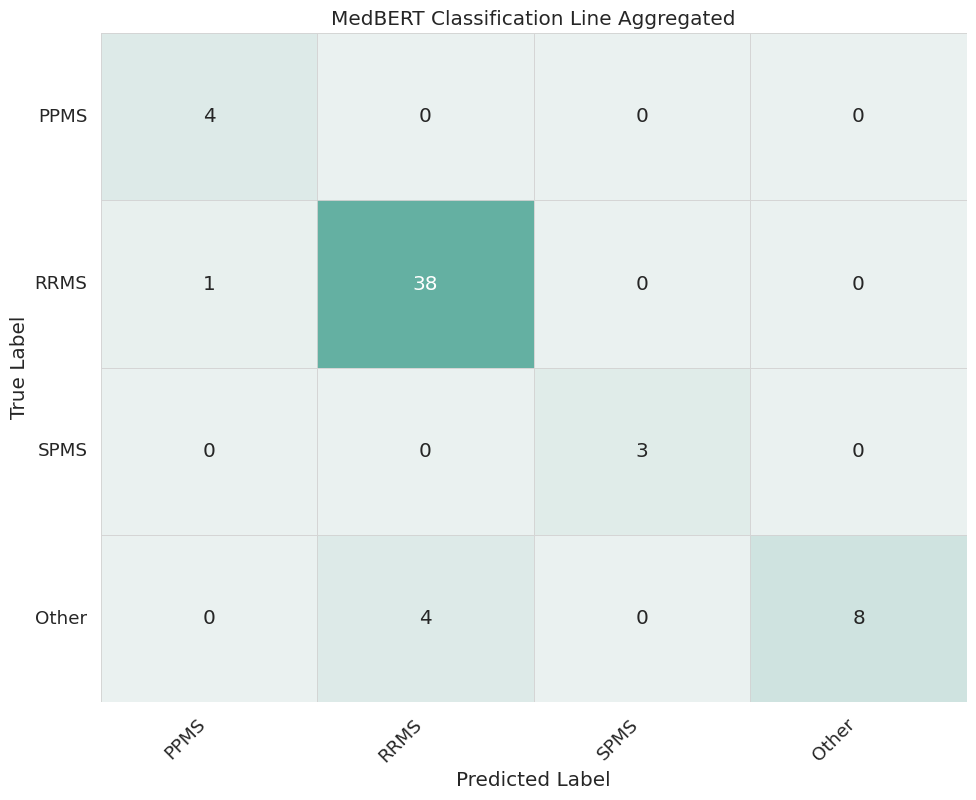

(58, 2)


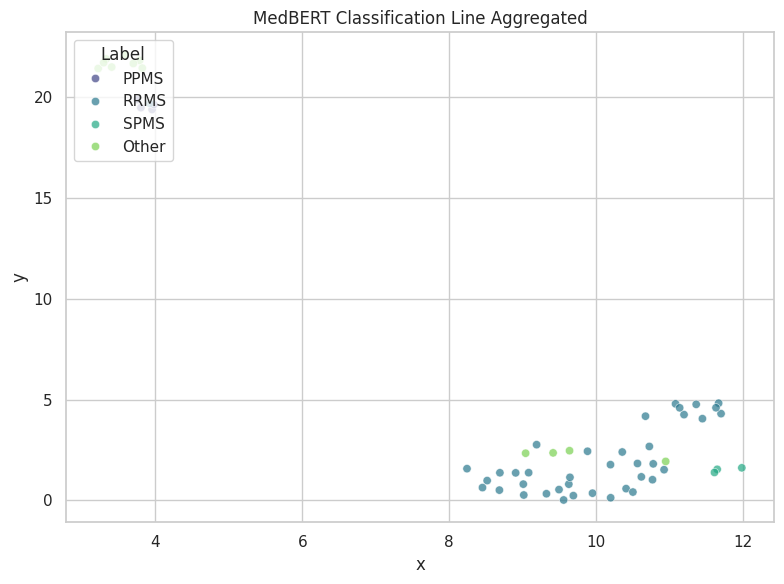

              precision    recall  f1-score   support

       Other       1.00      0.67      0.80        12
        PPMS       0.80      1.00      0.89         4
        RRMS       0.90      0.97      0.94        39
        SPMS       1.00      1.00      1.00         3

    accuracy                           0.91        58
   macro avg       0.93      0.91      0.91        58
weighted avg       0.92      0.91      0.91        58
 


Observation: 7
Label: Other - Prediction: RRMS
Cerebrale FLAIR-Hyperintensitäten bislang ungeklärter Ätiologie, EM 07/2012, ED 02/2014, EDSS 0.0
INDENT Ätiologisch: Unklar, DD vaskulär, DD schubförmige Multiple Sklerose eher unwahrscheinlich
INDENT Klinisch/aktuell: nihil
INDENT Verlauf:
INDENT 08/2012 Anamnestisch Unteramschwäche beidseits über drei Tage
INDENT seit 09/2012 intermittierend stechende Muskelschmerzen und passagere Dysästhesien im Bereich beider Arme und Beine, an Frequenz und Dauer nicht zunehmend
INDENT Diagnostik:
INDENT 12/2012 MRI Gehir

In [5]:
show_results("ms-diag_medbert-512_class_line_oversample_test_agg.pt", plot_hidden_states=True, plot_title="MedBERT Classification Line Aggregated")

The bad precision stems from the fact the we have an imbalanced dataset. Even though only 4 RRMS get classified wrong, it makes a huge difference for the precision of PPMS and SPMS as there are only so few examples.

## Strategy: Classify on single lines, 3 Labels (original approach with only dm samples) and oversampling for training

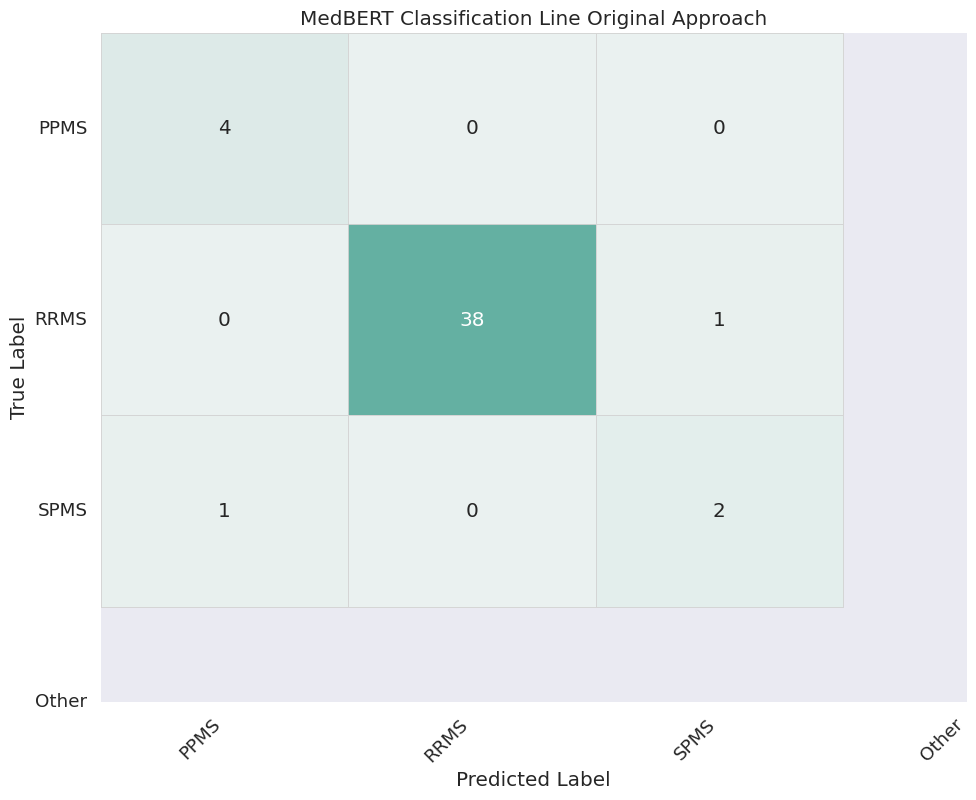

(46, 2)


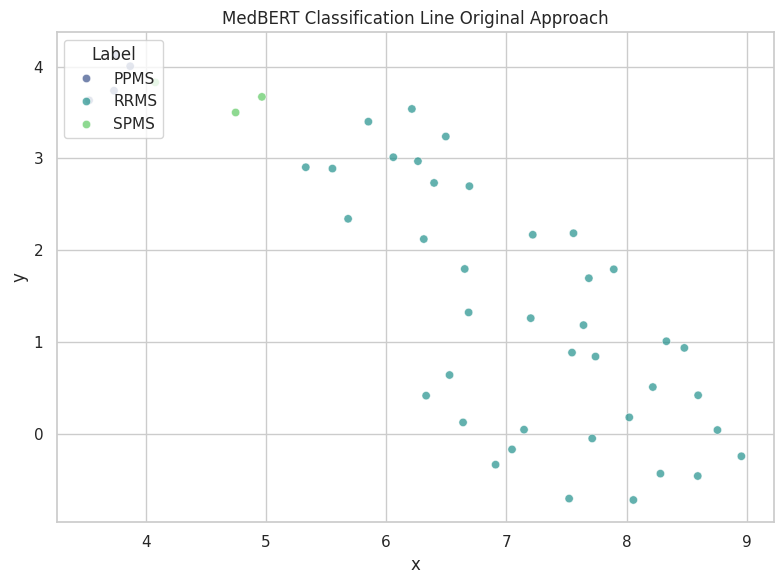

              precision    recall  f1-score   support

        PPMS       0.80      1.00      0.89         4
        RRMS       1.00      0.97      0.99        39
        SPMS       0.67      0.67      0.67         3

    accuracy                           0.96        46
   macro avg       0.82      0.88      0.85        46
weighted avg       0.96      0.96      0.96        46
 


Observation: 17
Label: SPMS - Prediction: PPMS
Sekundär progrediente Multiple Sklerose (EM 1998, ED 1999), EDSS 7.0
Probabilities: {'primary_progressive_multiple_sclerosis': 0.989, 'relapsing_remitting_multiple_sclerosis': 0.005, 'secondary_progressive_multiple_sclerosis': 0.005} 


Observation: 41
Label: RRMS - Prediction: SPMS
Schubförmige Multiple Sklerose mit Residuen, EM 2000, ED 2006, EDSS 6.5
Probabilities: {'primary_progressive_multiple_sclerosis': 0.003, 'relapsing_remitting_multiple_sclerosis': 0.378, 'secondary_progressive_multiple_sclerosis': 0.619} 




In [6]:
show_results("ms-diag_medbert-512_class_line_original_approach_test.pt", plot_title="MedBERT Classification Line Original Approach")

## Strategy: Classify on whole report, 4 labels (including no ms) training on oversampled

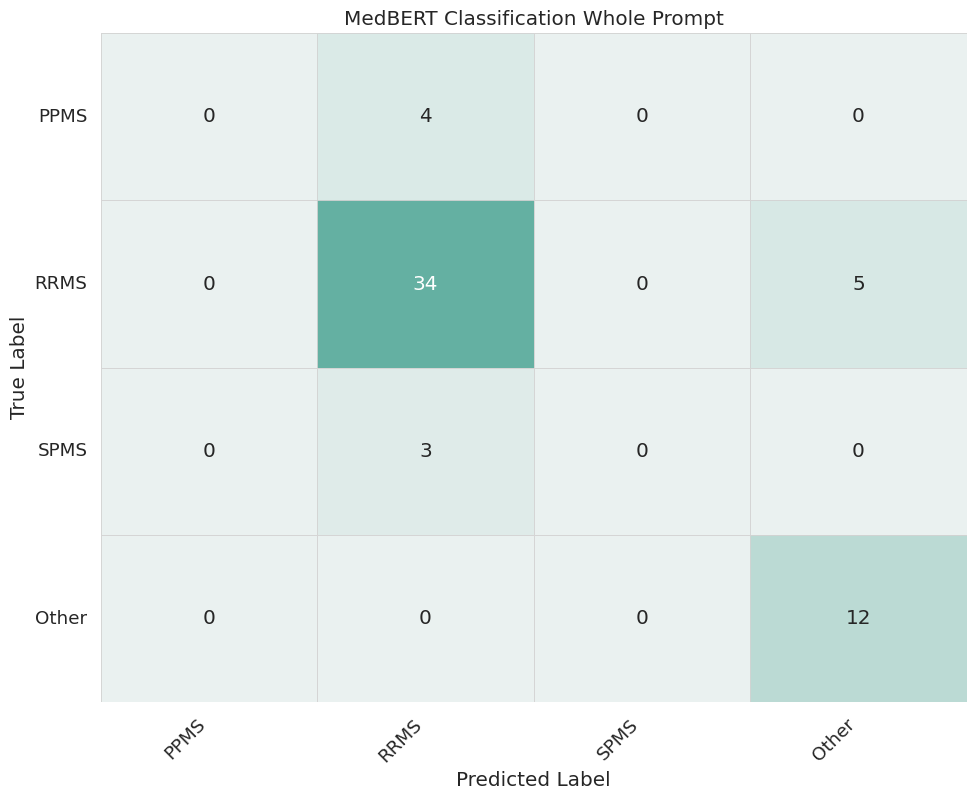

(58, 2)


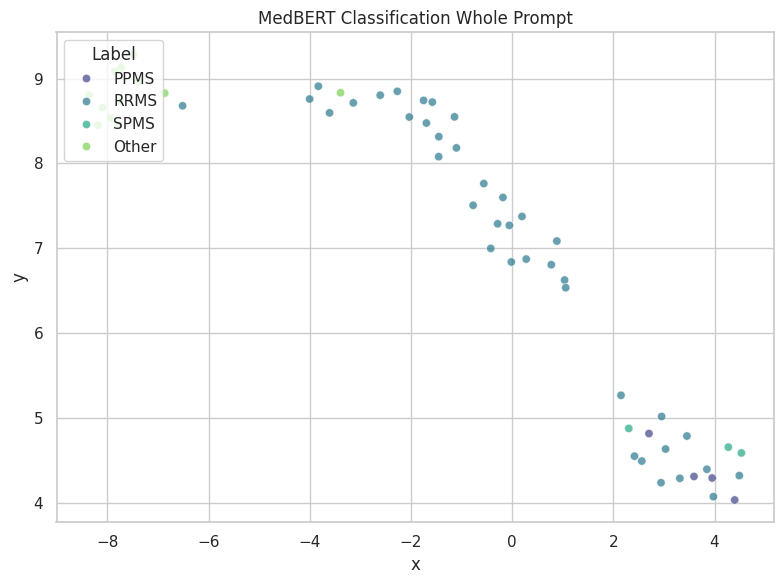

              precision    recall  f1-score   support

       Other       0.71      1.00      0.83        12
        PPMS       0.00      0.00      0.00         4
        RRMS       0.83      0.87      0.85        39
        SPMS       0.00      0.00      0.00         3

    accuracy                           0.79        58
   macro avg       0.38      0.47      0.42        58
weighted avg       0.70      0.79      0.74        58
 


Observation: 2
Label: PPMS - Prediction: RRMS
Primär chronisch progrediente Multiple Sklerose, EM 2008, ED 2012, EDSS 4.0
aktuell: klinisch: stabil, radiologisch: stabil, Progression: ja (nach Lublin et al. 2013)
INDENT Besserung der Kraft im linken Bein. Probleme beim Laufen, leichte Urge-Symptomatik und gelegentliche Einschlafprobleme. Klinisch spastisch-ataktisches Gangbild mit linksbetonter Spastik in den UE, beidseits gesteigerter PSR, Fallneigung im Rombergstehversuch nach hinten. Leichte Pallhypästhesie der UE (6/8).
INDENT Verlauf: 
INDENT 1996 Stu

/mnt/c/Users/marc_/OneDrive/ETH/MSC_Thesis/inf-extr/resources/inf-extr-BlECHwmE-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/marc_/OneDrive/ETH/MSC_Thesis/inf-extr/resources/inf-extr-BlECHwmE-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/marc_/OneDrive/ETH/MSC_Thesis/inf-extr/resources/inf-extr-BlECHwmE-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and bein

In [7]:
show_results("ms-diag_medbert-512_class_all_oversample_test.pt", plot_title="MedBERT Classification Whole Prompt")

## Strategy: Classify on whole report, 3 Labels (original approach with only reports containing at least one dm line), oversampling for training

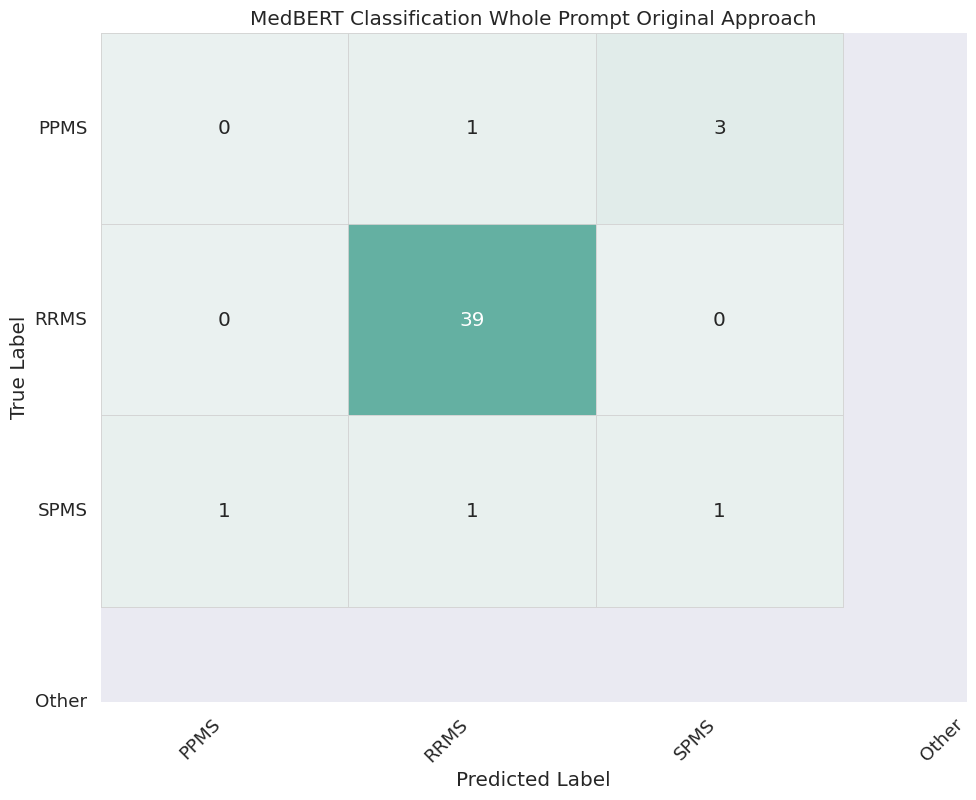

(46, 2)


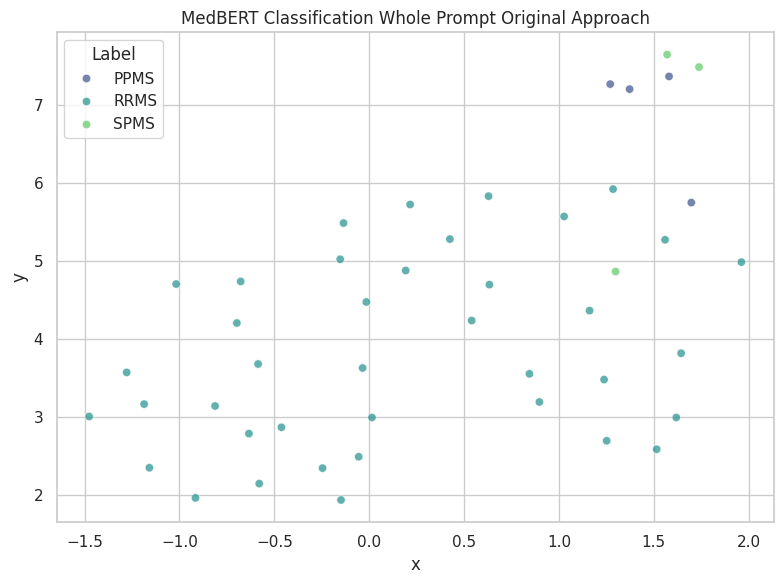

              precision    recall  f1-score   support

        PPMS       0.00      0.00      0.00         4
        RRMS       0.95      1.00      0.97        39
        SPMS       0.25      0.33      0.29         3

    accuracy                           0.87        46
   macro avg       0.40      0.44      0.42        46
weighted avg       0.82      0.87      0.85        46
 


Observation: 2
Label: PPMS - Prediction: SPMS
Primär chronisch progrediente Multiple Sklerose, EM 2008, ED 2012, EDSS 4.0
aktuell: klinisch: stabil, radiologisch: stabil, Progression: ja (nach Lublin et al. 2013)
INDENT Besserung der Kraft im linken Bein. Probleme beim Laufen, leichte Urge-Symptomatik und gelegentliche Einschlafprobleme. Klinisch spastisch-ataktisches Gangbild mit linksbetonter Spastik in den UE, beidseits gesteigerter PSR, Fallneigung im Rombergstehversuch nach hinten. Leichte Pallhypästhesie der UE (6/8).
INDENT Verlauf: 
INDENT 1996 Sturz mit dem Rad
INDENT 2008 Lähmung des linken Beines n

In [8]:
show_results("ms-diag_medbert-512_class_all_original_approach_test.pt", plot_title="MedBERT Classification Whole Prompt Original Approach")

## Pipeline Approach:

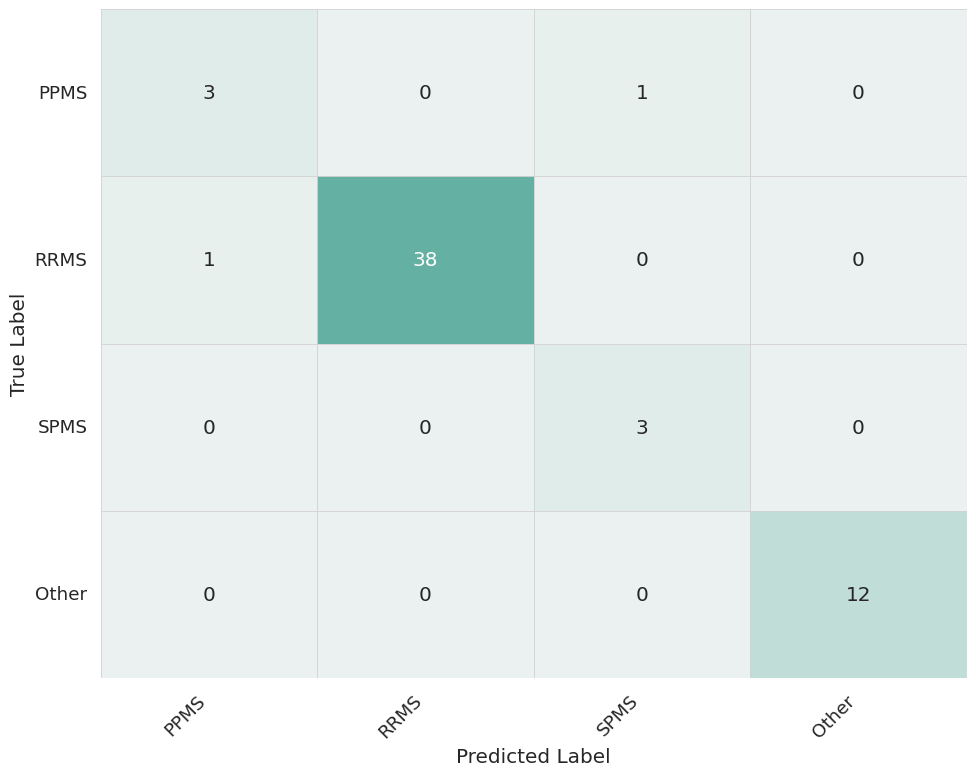

(46, 2)


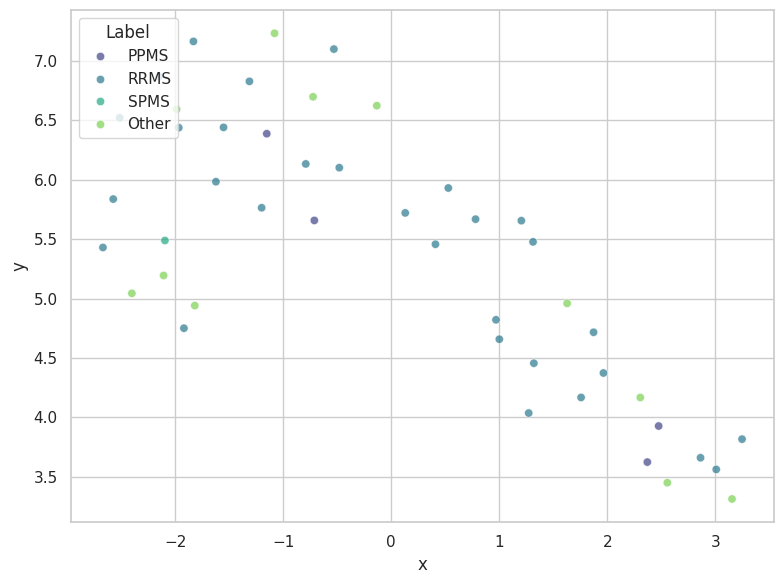

              precision    recall  f1-score   support

       Other       1.00      1.00      1.00        12
        PPMS       0.75      0.75      0.75         4
        RRMS       1.00      0.97      0.99        39
        SPMS       0.75      1.00      0.86         3

    accuracy                           0.97        58
   macro avg       0.88      0.93      0.90        58
weighted avg       0.97      0.97      0.97        58
 


Observation: 25
Label: RRMS - Prediction: PPMS
Hochgradiger V.a. entzündliche ZNS-Erkrankung ED 03.05.2019, EM 30.04.2019
INDENT ätiologisch: möglicherweise multiple Sklerose
INDENT anamnestisch: seit 4 Tagen aufsteigende Dysästhesie von den Füssen bis etwa T12, distal betont; St. n. Atemwegsinfektion vor einigen Tagen
INDENT klinisch: Dysästhesie sub Th12, Hypopallästhesie malleolar bds 7/8, Lagesinn und Temperatursinn erhalten,  keine Visusstörungen, leicht gesteigerte Reflexe (BSR und PSR bds) 
INDENT diagnostisch
INDENT MRI BWS/HWS 03.05.2019: Intraspi

In [9]:
show_results("ms-diag_medbert-512_pipeline_test.pt")

In [10]:
# Label of obs 25 is wrong, should be Other
results_corrected = torch.load(paths.RESULTS_PATH / "ms-diag" / "ms-diag_medbert-512_pipeline_test.pt")
results_corrected["labels"][25] = 3

torch.save(results_corrected, paths.RESULTS_PATH / "ms-diag" / "ms-diag_medbert-512_pipeline_test_corrected.pt")

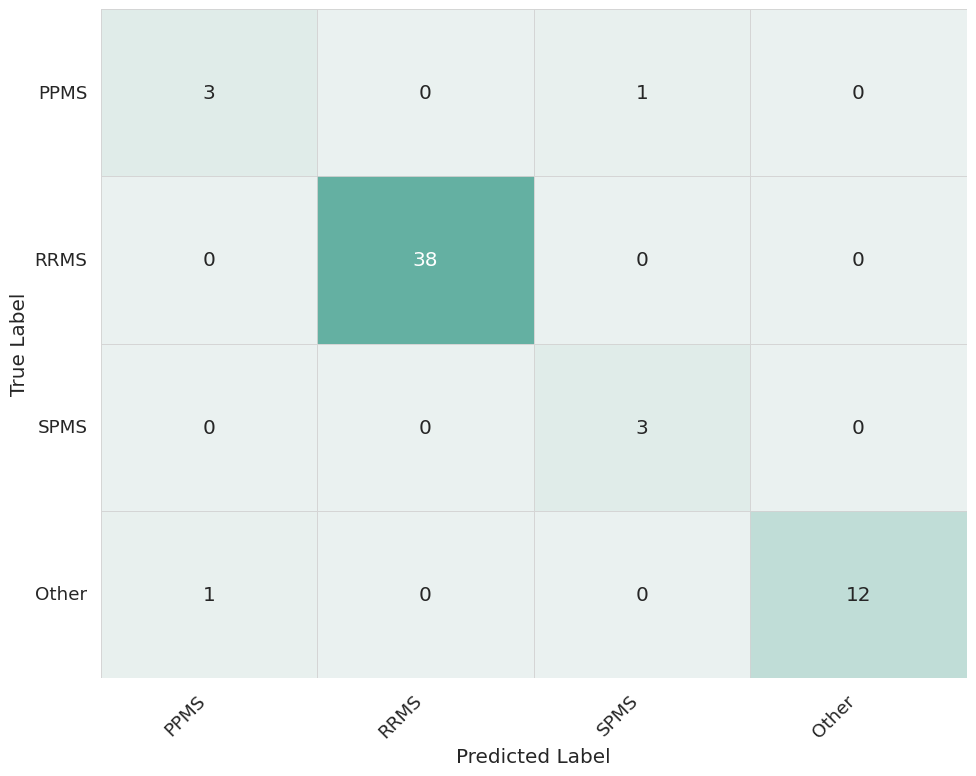

(46, 2)


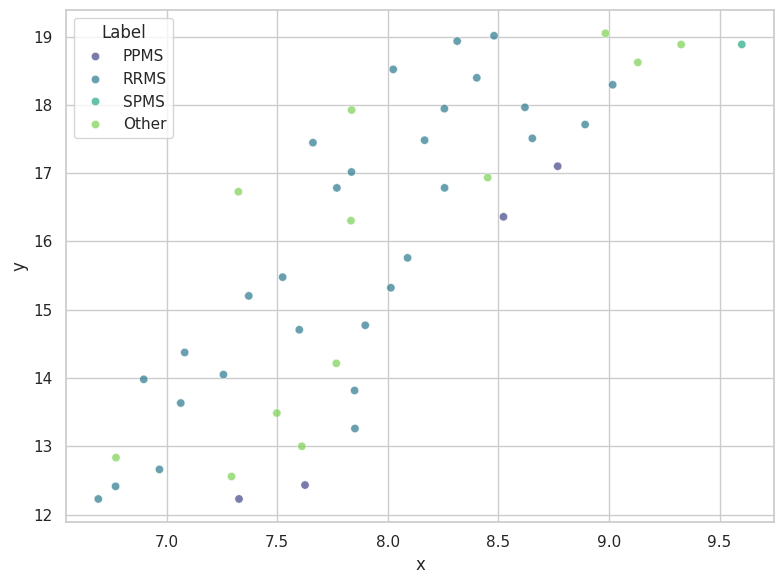

              precision    recall  f1-score   support

       Other       1.00      0.92      0.96        13
        PPMS       0.75      0.75      0.75         4
        RRMS       1.00      1.00      1.00        38
        SPMS       0.75      1.00      0.86         3

    accuracy                           0.97        58
   macro avg       0.88      0.92      0.89        58
weighted avg       0.97      0.97      0.97        58
 


Observation: 25
Label: Other - Prediction: PPMS
Hochgradiger V.a. entzündliche ZNS-Erkrankung ED 03.05.2019, EM 30.04.2019
INDENT ätiologisch: möglicherweise multiple Sklerose
INDENT anamnestisch: seit 4 Tagen aufsteigende Dysästhesie von den Füssen bis etwa T12, distal betont; St. n. Atemwegsinfektion vor einigen Tagen
INDENT klinisch: Dysästhesie sub Th12, Hypopallästhesie malleolar bds 7/8, Lagesinn und Temperatursinn erhalten,  keine Visusstörungen, leicht gesteigerte Reflexe (BSR und PSR bds) 
INDENT diagnostisch
INDENT MRI BWS/HWS 03.05.2019: Intrasp

In [11]:
show_results("ms-diag_medbert-512_pipeline_test_corrected.pt")

In [17]:
# Additionally to compare to old approach remove other labels
other_idx = [i for i, label in enumerate(results_corrected["labels"]) if label == 3]
results_corrected_no = {}
for key in results_corrected.keys():
    results_corrected_no[key] = [value for i, value in enumerate(results_corrected[key]) if i not in other_idx]

torch.save(results_corrected_no, paths.RESULTS_PATH / "ms-diag" / "ms-diag_medbert-512_pipeline_test_corrected_no_other.pt")

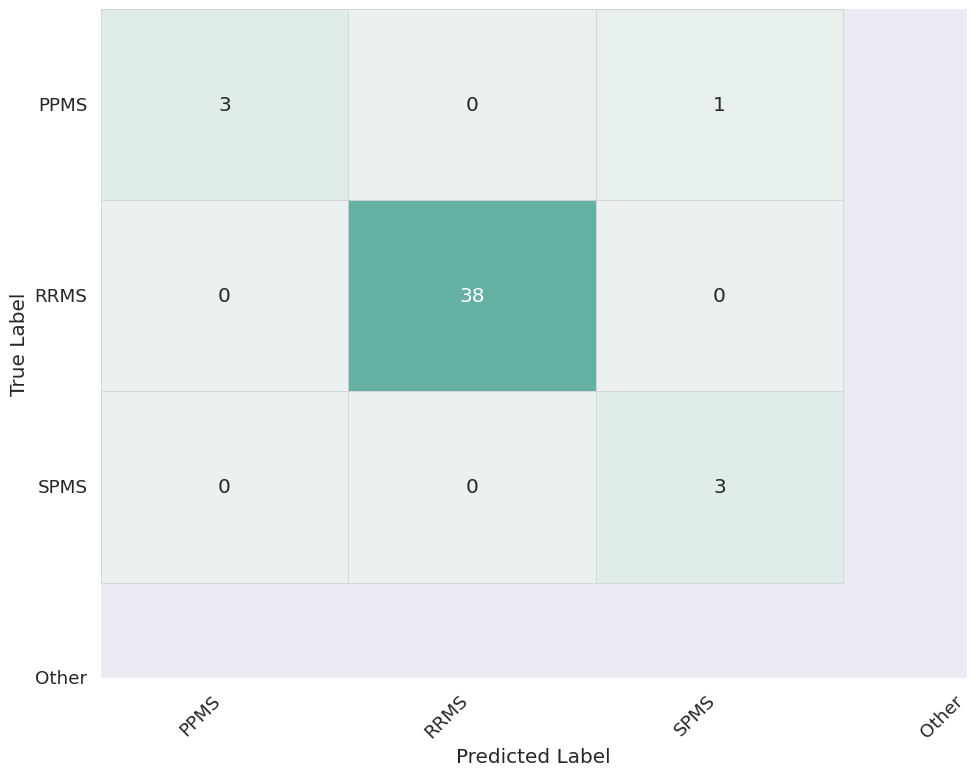

(45, 2)


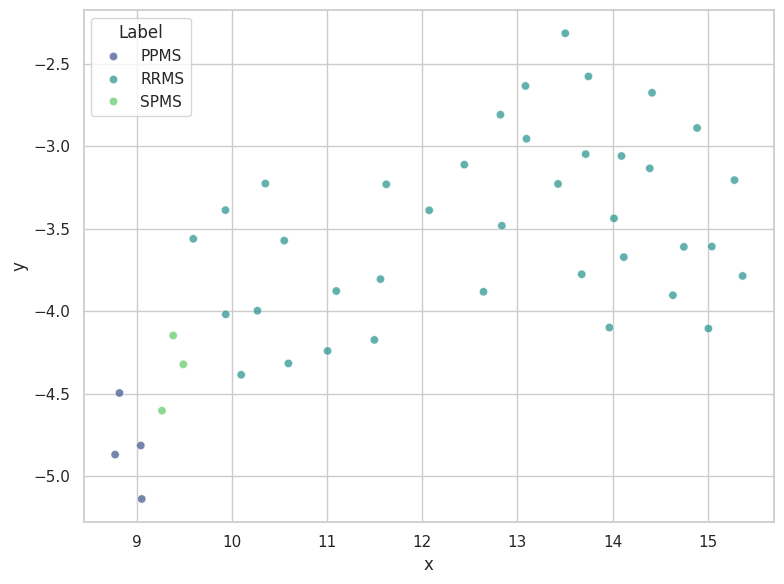

              precision    recall  f1-score   support

        PPMS       1.00      0.75      0.86         4
        RRMS       1.00      1.00      1.00        38
        SPMS       0.75      1.00      0.86         3

    accuracy                           0.98        45
   macro avg       0.92      0.92      0.90        45
weighted avg       0.98      0.98      0.98        45
 


Observation: 21
Label: PPMS - Prediction: SPMS
1. Multiple Sklerose a.e. primär progredient, EM 2011, ED 03/2015, EDSS 3.5
INDENT klinisch: nicht aktiv, radiologisch: nicht aktiv, Progression: nein (nach Lublin et al. 2013)
INDENT aktuell: im langfristigen Verlauf langsame Besserung der spastisch-ataktischen Gangstörung 
Verlauf:
INDENT 1997 Episode mit aufsteigenden Sensibilitätsstörungen der Beine. Abklärungen erfolgten in der Neurologie USZ (LP, MRI, evozierte Potentiale), eine Diagnose wurde jedoch nicht gestellt 
INDENT 1997-2011 Anamnestisch keine neurologische Symptomatik eruierbar
INDENT 2011-2016 lan

In [18]:
show_results("ms-diag_medbert-512_pipeline_test_corrected_no_other.pt")